In [1]:
# Customization imports

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import time

# Export dataFrame's as images
import dataframe_image as dfi

In [2]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import auc as auc_temp

In [3]:
# import my utility methods for this project
import utils_practical_2 as my_utils

In [4]:
# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [5]:
# Global format rules

# Page width to use for wide figures - make it consistent across the project
page_width=10

# Clean up axes labels
axes_fonts = {'fontweight': 'bold'}
title_fonts = {'fontweight': 'bold', 'fontsize': 14}

# Seaborn over-rides
sns.set_theme(style='darkgrid')

# On to Modeling ...

**This notebook picks up from the Data Investigation (see ```DataInvestigation.ipynb```)**

[Local file](DataInvestigation.ipynb)
[Github](https://github.com/fazeelgm/UCB_ML_AI_PracticalApp_II/blob/main/DataInvestigation.ipynb)

## Data Cleanup

The data cleansing results are as follows:

In [9]:
# vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

In [10]:
# vehicles_cleansed.info()

# On to Modeling ...

While investigating the different features of our dataset during the data investigation, I learned two things:

1. The data is very noisy with extreme outliers - I removed null data and outliers as much as possible
   * 66,180 samples were dropped, preserving 84.50% of the original data
3. To aid in this effort, I researched the used car marketplace to get some idea of pricing, important features that drive price and potential inventory segments

## Initial Hypothesis

Based on Price inspection, a potential hypothesis arose that the used car inventory is _segmented_ based on the following price bands:

![](images/candidate-price-segments.png)

In addition, market research suggested that typical used cars can be categoriezed into price ranges like Budget, Mid, Luxury, etc. that will be based on feature groups. I looked at ```<price, year, condition, odometer>``` combinations and saw that there was clustering behavior as shown by the scatter plots below:

![](images/scatter-price-odo-condition-budget.png)
![](images/scatter-price-odo-year-entry.png)

So, I will now use clustering techniques to see if we can observe natural clustering of features in our sample population.

# Final Modeling

## Data Cleaning

In [15]:
vehicles_raw, vehicles_cleansed = my_utils.get_cleansed_data()

Reading data/vehicles.csv ... Done: (426880, 18)

Cleansing price column ... 
... Removing price outliers using ModZ method ... 
... ModZ: 9450.0, med: 13950.0, const: 0.6745
... Time: 0.15172886848449707
... Removed 5,790 outliers
... Removing cars with price = 0 ...  Removed 32,895 rows
Done: (421090, 19) -> (388195, 19)

DropNA from columns: 
... year: 1,029 rows (0.27% of total): 388,195 -> 387,166
... manufacturer: 16,609 rows (4.28% of total): 388,195 -> 371,586
... fuel: 19,173 rows (4.94% of total): 388,195 -> 369,022
... title_status: 26,730 rows (6.89% of total): 388,195 -> 361,465
... odometer: 28,960 rows (7.46% of total): 388,195 -> 359,235
... transmission: 30,742 rows (7.92% of total): 388,195 -> 357,453
Done: (388195, 19) -> (360700, 19)

Dropping columns: ['mod_zscore', 'id', 'model', 'VIN']
... mod_zscore
... id
... model
... VIN
Done: (360700, 19) -> (360700, 15)

Data Transformations:
... year float -> int: Done
... odometer float -> int: Done

Category Transformati

In [16]:
vehicles_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        360700 non-null  object  
 1   price         360700 non-null  int64   
 2   year          360700 non-null  int64   
 3   manufacturer  360700 non-null  category
 4   condition     223668 non-null  category
 5   cylinders     213522 non-null  category
 6   fuel          360700 non-null  category
 7   odometer      360700 non-null  int64   
 8   title_status  360700 non-null  category
 9   transmission  360700 non-null  category
 10  drive         252582 non-null  category
 11  size          104338 non-null  category
 12  type          282300 non-null  category
 13  paint_color   257706 non-null  category
 14  state         360700 non-null  category
dtypes: category(11), int64(3), object(1)
memory usage: 17.5+ MB


In [17]:
vehicles_cleansed.columns

Index(['region', 'price', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state'],
      dtype='object')

In [18]:
# Create a copy of the clean data
data = vehicles_cleansed.copy()

ADD COMMENTARY HERE

In [20]:
# Remove unwanted columns
drop_cols = ['region', 'manufacturer', 'paint_color', 'state']
# drop_cols = ['region', 'manufacturer', 'paint_color', 'state', 'size']
data.drop(columns=drop_cols, inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360700 entries, 27 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         360700 non-null  int64   
 1   year          360700 non-null  int64   
 2   condition     223668 non-null  category
 3   cylinders     213522 non-null  category
 4   fuel          360700 non-null  category
 5   odometer      360700 non-null  int64   
 6   title_status  360700 non-null  category
 7   transmission  360700 non-null  category
 8   drive         252582 non-null  category
 9   size          104338 non-null  category
 10  type          282300 non-null  category
dtypes: category(8), int64(3)
memory usage: 13.8 MB


In [22]:
# DataFrame containing rows with any null values
data_with_nulls = data[data.isnull().any(axis=1)]

# DataFrame containing rows with all non-null values
data_without_nulls = data[~data.isnull().any(axis=1)]

# Print the resulting DataFrames
print(f'Data with nulls: {data_with_nulls.shape}')
print(f'\nDataFrame without nulls: {data_without_nulls.shape}')

Data with nulls: (282074, 11)

DataFrame without nulls: (78626, 11)


In [23]:
# remove nulls before splitting data

dropna_cols = ['condition', 'cylinders', 'drive', 'type']

print('Dropping nulls: {} -> '.format(data.shape), end='')
# data.dropna(subset=['condition', 'cylinders', 'drive', 'size', 'type'], axis='index', inplace=True)
data.dropna(subset=dropna_cols, axis='index', inplace=True)
print(' {}'.format(data.shape))

Dropping nulls: (360700, 11) ->  (122682, 11)


In [24]:
data.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'title_status', 'transmission', 'drive', 'size', 'type'],
      dtype='object')

## Feature Transformation for Modeling

### Create Train/Test splits

In [27]:
X = data.drop('price', axis='columns')
y = data['price']

# OneHot Encode the features
X = pd.get_dummies(X, drop_first=True)

random_state = 13
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [28]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122682 entries, 31 to 426878
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   year                     122682 non-null  int64
 1   odometer                 122682 non-null  int64
 2   condition_fair           122682 non-null  bool 
 3   condition_good           122682 non-null  bool 
 4   condition_like new       122682 non-null  bool 
 5   condition_new            122682 non-null  bool 
 6   condition_salvage        122682 non-null  bool 
 7   cylinders_12 cylinders   122682 non-null  bool 
 8   cylinders_3 cylinders    122682 non-null  bool 
 9   cylinders_4 cylinders    122682 non-null  bool 
 10  cylinders_5 cylinders    122682 non-null  bool 
 11  cylinders_6 cylinders    122682 non-null  bool 
 12  cylinders_8 cylinders    122682 non-null  bool 
 13  cylinders_other          122682 non-null  bool 
 14  fuel_electric            122682 non-null

### Feature Scaling

In [30]:
# Scale the data - we'll use StandardScaler for the baseline models
logging.debug('Scaling data')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Baseline Regression Models

In [32]:
# Setup the linear models
models = {
    'LinearRegression' : LinearRegression(),
    'Ridge' : Ridge(alpha=1.0),
    'Lasso' : Lasso(alpha=0.1, max_iter=2000)
}

# save results for tabulation
results_baseline = []

In [33]:
# Evaluate models
def get_model_metrics_as_results(name, clf, scaler, X_test, y_test, override_rmse=0):
    """
    Build standardized results row given the predictions and y_test values

    :param name: Model name for labeling the row in the table
    :param clf: Fitted classifier to get metrics
    :param scaler: Fitted scaler used for transformation
    :param X_test: Test data used to fit the classifier
    :param y_test: Evaluation data to be used for the metrics
    :param override_rmse: Default 0 will internally calculate RMSE as np.sqrt(MSE), pass in a 
        value for cross-validated estimator result if needed
    :return: Returns single row of results summary table containing:
    
        [model_name, MAE, MSE, RMSE, R2_Score, y-intercept]
    """
    
    logging.debug(f'Working on {name}')

    # Get predictions
    y_preds = clf.predict(X_test)

    # get metrics
    mae = mean_absolute_error(y_preds, y_test)
    mse = mean_squared_error(y_preds, y_test)
    if override_rmse == 0:
        rmse = np.sqrt(mse)
    else:
        rmse=override_rmse
    r2 = r2_score(y_test, y_preds)
    score = clf.score(X_test, y_test)
    y_intercept = np.abs(clf.intercept_)
    sname = scaler.__class__.__name__
    
    logging.debug(f'... {name}: Scaler: {sname} MAE: {mae:,.4f}, MSE: {mse:,.4f}, RMSE: {rmse:,.4f}, Override RMSE: {override_rmse:,.4f}, R2: {r2:,.4f}, Score: {score:,.4f}, y-int: {y_intercept:,.4f}')

    return [name, sname, mae, mse, rmse, score, y_intercept]

In [34]:
# logging.getLogger().setLevel(logging.DEBUG)

In [35]:
# Run the baseline models

results_baseline = []

# iterate over the models and build results DF
for model in models:

    start_time = time.time()
    print(f'Working on {model} ... ', end='')

    # Fit the model
    models[model].fit(X_train_scaled, y_train)
    
    # Append model metrics to results
    results_baseline.append(get_model_metrics_as_results(model, models[model], scaler, X_test_scaled, y_test))

    print(f'Done with {model} ({time.time() - start_time:,.4f} sec)')

Working on LinearRegression ... Done with LinearRegression (0.1886 sec)
Working on Ridge ... Done with Ridge (0.0546 sec)
Working on Lasso ... Done with Lasso (2.4467 sec)


In [36]:
# logging.getLogger().setLevel(logging.INFO)

In [37]:
# Generate results table
results_baseline_df = pd.DataFrame(results_baseline, 
                                   columns=['Model', 'Scaler', 'MAE', 'MSE', 'RMSE', 'R2 Score', 'Base Price']
                                  ).set_index('Model')

# Sort by highest R2, lowest MAE
results_baseline_df.sort_values(by=['R2 Score', 'MAE'], ascending=[False, True], inplace=True)

# Export results for README
results_baseline_df_styled = my_utils.df_style_floats(results_baseline_df)
dfi.export(results_baseline_df_styled, 'images/results_baseline_table.png')

print('RESULTS: Baseline metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline metrics without any optimization



,Scaler,MAE,MSE,RMSE,R2 Score,Base Price
Model,,,,,,
Ridge,StandardScaler,"6,017.40170","73,199,860.87002","8,555.69172",0.52074,"15,690.10098"
Lasso,StandardScaler,"6,017.39949","73,199,867.28202","8,555.69210",0.52074,"15,690.10098"
LinearRegression,StandardScaler,"6,017.39651","73,199,868.02498","8,555.69214",0.52074,"15,690.10098"


All the models performed very closely without any clear winners. Given the target variable measurement unit, price in dollars per car:

* All the models showed roughly $8,287 (RMSE) average difference between the predicted and actual prices from the test dataset that was not used for the training of the model
* The R2 Score shows thay they each captured 42.77% of the variance in the price

We will now optimize the models to see if we can improve the results and pick a clear winner.

## Model Tuning: Hyperparameter Tuning and Cross Validation

In [158]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'LinearRegression': LinearRegression()
}

cv_param_grid = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0], 'random_state': [random_state]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0], 'random_state': [random_state], 'max_iter': [2000] }    
}

scalers = {
    StandardScaler(),
    RobustScaler(),    # default: quantile_range=(25, 75)
    MinMaxScaler()
}

In [160]:
# Toggle debugging output
# logging.getLogger().setLevel(logging.DEBUG)
# logging.getLogger().setLevel(logging.INFO)

In [162]:
#
# Set loops to cross-validate over model / scaler combinations using GridSearchCV
#

# save results for tabulation
results_tuned = []
best_models = {}
best_params = {}

# Cross-validation count
cv=2
verbosity=0

# Loop thru each scaler and transform the data
for scaler in scalers:

    print(f'Working on {scaler} ... ')
    logging.debug(f'Working on {scaler}')

    # Scale X_train
    logging.debug(f'Scaling data using {scaler}')
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    # Loop thru each model, fit/predict and store the results
    for model in models:

        start_time = time.time()

        # print(f'\tWorking on {model} ... ', end='')

        clf = models[model]

        # Handle CV models
        if (model in cv_param_grid):
            print('\tWorking on {} : {}, Scaler: {}'.format(model, cv_param_grid[model], scaler))
            grid = GridSearchCV(clf, param_grid=cv_param_grid[model], 
                                cv=cv, scoring='neg_mean_squared_error', verbose=verbosity)
            grid.fit(X_train_scaled, y_train)
              
            # Save the tuning metrics for this model class
            best_models[model] = grid.best_estimator_
            best_params[model] = grid.best_params_
            logging.debug(f'Best param: {grid.best_params_}')            
            rmse = np.sqrt(-grid.best_score_)

        # Handle non-CV models
        else:
            print('\tWorking on {}, Scaler: {}'.format(model, scaler))
            clf.fit(X_train_scaled, y_train)
            cv_scores = cross_val_score(clf, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')

            # Save the tuning metrics for this model class
            best_models[model] = clf
            best_params[model] = ''
            rmse = np.sqrt(-np.mean(cv_scores))

        y_preds = best_models[model].predict(X_test_scaled)

        # Get the predictions for this model instance
        score = best_models[model].score(X_test_scaled, y_test)
        r2 = r2_score(y_test, y_preds)
        logging.debug(f'CV Best RMSE: {rmse}')
        logging.debug(f'Score: {score}, r2: {r2}')
       
        # Append model metrics to results
        results_tuned.append(get_model_metrics_as_results(model, best_models[model], scaler, X_test_scaled, y_test, override_rmse=rmse))

        print(f'\tDone with {model} ({time.time() - start_time:,.4f} sec)')

    print(f'Done with {scaler}')

logging.getLogger().setLevel(logging.INFO)

Working on MinMaxScaler() ... 
	Working on Ridge : {'alpha': [0.1, 1.0, 10.0, 100.0], 'random_state': [13]}, Scaler: MinMaxScaler()
	Done with Ridge (0.3226 sec)
	Working on Lasso : {'alpha': [0.01, 0.1, 1.0, 10.0], 'random_state': [13], 'max_iter': [2000]}, Scaler: MinMaxScaler()
	Done with Lasso (6.6494 sec)
	Working on LinearRegression, Scaler: MinMaxScaler()
	Done with LinearRegression (0.4260 sec)
Done with MinMaxScaler()
Working on StandardScaler() ... 
	Working on Ridge : {'alpha': [0.1, 1.0, 10.0, 100.0], 'random_state': [13]}, Scaler: StandardScaler()
	Done with Ridge (0.3327 sec)
	Working on Lasso : {'alpha': [0.01, 0.1, 1.0, 10.0], 'random_state': [13], 'max_iter': [2000]}, Scaler: StandardScaler()
	Done with Lasso (7.2345 sec)
	Working on LinearRegression, Scaler: StandardScaler()
	Done with LinearRegression (0.2832 sec)
Done with StandardScaler()
Working on RobustScaler() ... 
	Working on Ridge : {'alpha': [0.1, 1.0, 10.0, 100.0], 'random_state': [13]}, Scaler: RobustScale

In [43]:
# Generate results table
results_tuned_df = pd.DataFrame(results_tuned,
                                columns=['Model - Tuned', 'Scaler', 'MAE', 'MSE', 'RMSE', 'R2 Score', 'Base Price']
                               ).set_index('Model - Tuned')

# Add BestParams as a new column
results_tuned_df['CV Best Params'] = results_tuned_df.index.map(best_params)

# Sort by highest R2, lowest MAE
results_tuned_df.sort_values(by=['R2 Score', 'MAE'], ascending=[False, True], inplace=True)

# Export results for README
results_tuned_df_styled = my_utils.df_style_floats(results_tuned_df)
dfi.export(results_tuned_df_styled, 'images/results_tuned_table.png')

## Best Model Assessment

### Picking the Best Model

In [46]:
print('RESULTS: Baseline Model metrics without any optimization\n')
results_baseline_df_styled

RESULTS: Baseline Model metrics without any optimization



,Scaler,MAE,MSE,RMSE,R2 Score,Base Price
Model,,,,,,
Ridge,StandardScaler,"6,017.40170","73,199,860.87002","8,555.69172",0.52074,"15,690.10098"
Lasso,StandardScaler,"6,017.39949","73,199,867.28202","8,555.69210",0.52074,"15,690.10098"
LinearRegression,StandardScaler,"6,017.39651","73,199,868.02498","8,555.69214",0.52074,"15,690.10098"


In [47]:
print('RESULTS: Optimized Model results after hyperparameter tuning and cross-validation\n')
results_tuned_df_styled

RESULTS: Optimized Model results after hyperparameter tuning and cross-validation



,Scaler,MAE,MSE,RMSE,R2 Score,Base Price,CV Best Params
Model - Tuned,,,,,,,
Ridge,StandardScaler,"6,017.96847","73,199,505.45871","8,501.41147",0.52074,"15,690.10098","{'alpha': 100.0, 'random_state': 13}"
LinearRegression,StandardScaler,"6,017.39651","73,199,868.02498","8,501.43474",0.52074,"15,690.10098",
Lasso,StandardScaler,"6,017.43083","73,199,924.16604","8,501.42018",0.52074,"15,690.10098","{'alpha': 1.0, 'random_state': 13}"
LinearRegression,RobustScaler,"6,016.21553","73,242,250.40187","8,501.43474",0.52046,"14,291.35890",
Ridge,RobustScaler,"6,016.22478","73,242,266.29807","8,501.21122",0.52046,"14,398.73150","{'alpha': 100.0, 'random_state': 13}"
Lasso,RobustScaler,"6,016.70425","73,253,607.97205","8,501.17252",0.52039,"14,190.22048","{'alpha': 1.0, 'random_state': 13}"
Lasso,MinMaxScaler,"5,850.92986","75,054,983.08685","8,501.18530",0.50859,"18,532.62024","{'alpha': 1.0, 'random_state': 13}"
Ridge,MinMaxScaler,"5,848.96711","75,070,098.79079","8,501.27504",0.50849,"18,423.72315","{'alpha': 100.0, 'random_state': 13}"
LinearRegression,MinMaxScaler,"5,845.38077","75,102,333.90408","8,501.43474",0.50828,"18,457.03515",


In [48]:
best_model_idx = 0   # ASSUMES SORTED LIST
results_row = results_tuned_df.iloc[best_model_idx]
best_model_name = results_tuned_df.index[best_model_idx]
best_model = best_models[best_model_name]
y_intercept = np.float64(results_row['Base Price'].replace(',',''))

print('Best Model with highest R2 Score: {}\n\tBest Params: {}\n\tScaler: {}\n\tR2 Score: {:,.2f}%\n\tRMSE: ${:,.2f}\n\tBase Price (y-intercept): ${:,.2f}'
      .format(best_model_name,
              results_row['CV Best Params'],
              results_row['Scaler'],
              float(results_row['R2 Score']) * 100, 
              float(results_row['RMSE'].replace(',','')),
              y_intercept))

Best Model with highest R2 Score: Ridge
	Best Params: {'alpha': 100.0, 'random_state': 13}
	Scaler: StandardScaler
	R2 Score: 52.07%
	RMSE: $8,501.41
	Base Price (y-intercept): $15,690.10


Again, all the models performed very closely without any clear winners. 

However, the optimized Ridge Model with alpha=10.0 showed the least average difference between predicted and actual prices (\\$8,281.94 vs \\$8,287 RMSE) and a captured more variance across the features (42.85%  vs 42.77% R2 Score) for the **best performing Ridge model**. 

In addition, the base price of a car is given by the y-intercept for the model: $22,490.54, with each feature adding or subtracting from this value based on the training features.

### Visualizing Actual vs Predicted Prices

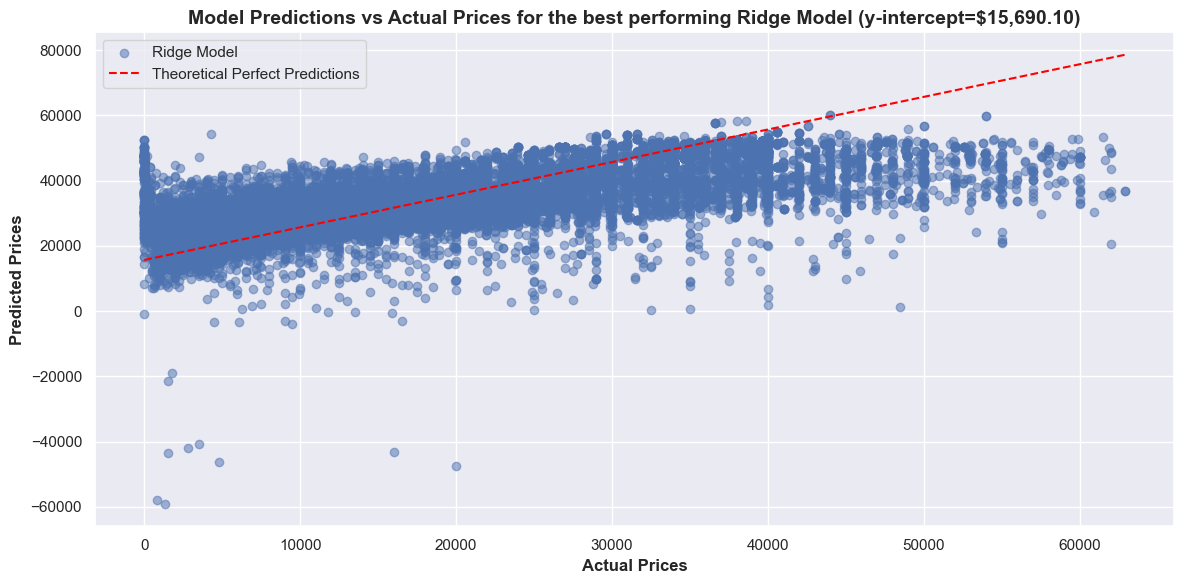

In [51]:
# Plot predictions
y_preds = best_model.predict(X_test_scaled)

# Adjust for the y-intercept
y_preds = np.add(y_preds, y_intercept)
perfect_pt_1 = [min(y_test), max(y_test)]
perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept

plt.figure(figsize=(12, 6))
plt.scatter(x=y_test, y=y_preds, label=f'{best_model_name} Model', alpha=0.5)
plt.plot(perfect_pt_1, perfect_pt_2, color='red', linestyle='--', label='Theoretical Perfect Predictions')

plt.xlabel('Actual Prices', fontdict=axes_fonts)
plt.ylabel('Predicted Prices', fontdict=axes_fonts)
plt.title(f'Model Predictions vs Actual Prices for the best performing {best_model_name} Model (y-intercept=${y_intercept:,.2f})', 
          fontdict=title_fonts)
plt.legend()
plt.tight_layout()

plt.savefig('images/scatter-optimized-preds-v-test.png')
plt.show()

### PredictionErrorDisplay: Residuals Comparison

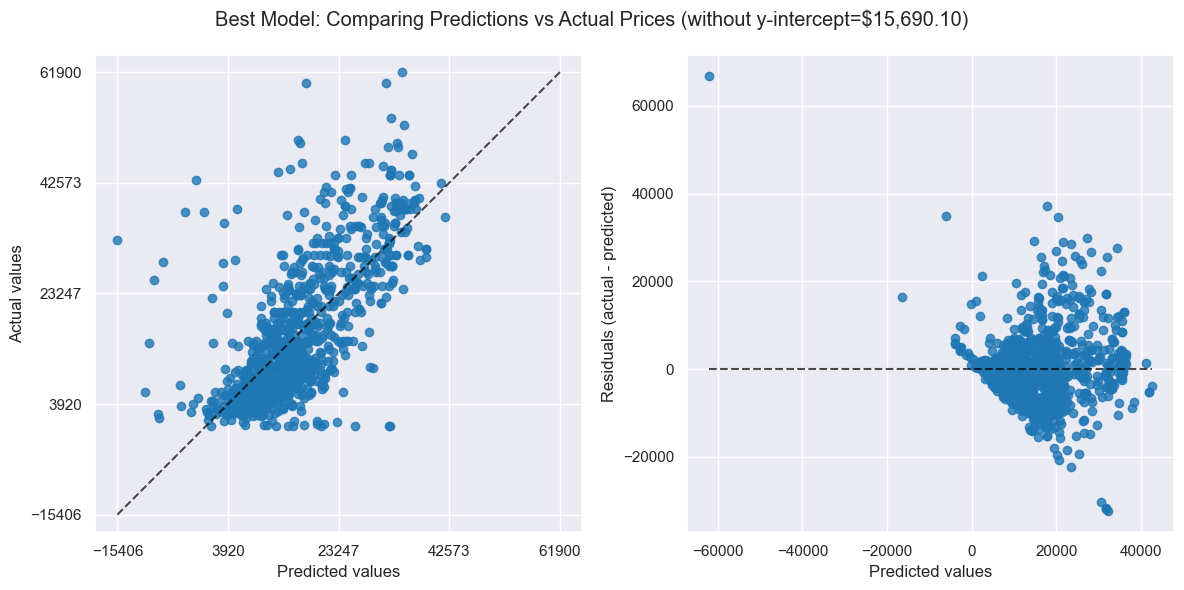

In [53]:
# # How to get the list of available Displays for my version of sklearn
# from sklearn.utils.discovery import all_displays
# displays = all_displays()
# displays

from sklearn.metrics import PredictionErrorDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[0], kind="actual_vs_predicted")
PredictionErrorDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1], kind="residual_vs_predicted")

plt.suptitle(f'Best Model: Comparing Predictions vs Actual Prices (without y-intercept=${y_intercept:,.2f})')
plt.tight_layout()

plt.savefig('images/optimized-PredictionErrorDisplay.png')
plt.show()

### Interpreting the Model Results

In [55]:
# logging.getLogger().setLevel(logging.DEBUG)

In [56]:
# build the feature importance DF

feature_names = X.columns

feature_imp = []
for feature, coef in zip(feature_names, best_model.coef_):
    if coef != 0:
        # print(f'{feature}: {coef}')
        feature_imp.append([feature, coef])

feature_imp_df = pd.DataFrame(data=feature_imp, columns=['Feature', 'Coefficient'])#.set_index('Feature')
feature_imp_df['Importance'] = np.abs(feature_imp_df.Coefficient)

# Sort the DF
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Add cumulative importance
feature_imp_df['Cumulative Importance'] = feature_imp_df['Importance'].cumsum() / feature_imp_df['Importance'].sum()
feature_imp_df['Percent Contribution'] = feature_imp_df['Cumulative Importance'] * 100

print(f'Impact of each feature to the Base Price: ${y_intercept:,.2f} (y-intercept)')
feature_imp_df_styled = my_utils.df_style_floats(feature_imp_df[['Feature', 'Coefficient', 'Percent Contribution']]
                                                 .set_index('Feature').rename(columns={'Coefficient':'Price Impact'}))

logging.getLogger().setLevel(logging.INFO)
feature_imp_df_styled.head()

Impact of each feature to the Base Price: $15,690.10 (y-intercept)


,Price Impact,Percent Contribution
Feature,,
year,"3,679.95092",11.74560
transmission_other,"3,672.19835",23.46645
fuel_gas,"-2,251.39195",30.65240
cylinders_8 cylinders,"2,054.32284",37.20935
drive_fwd,"-1,851.90022",43.12021


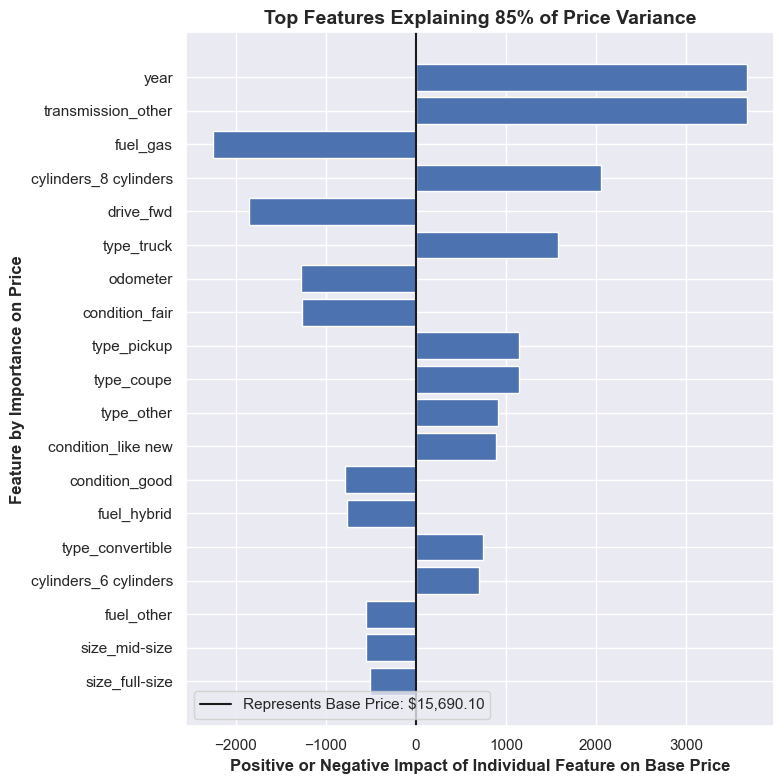

In [57]:
# Top features that explain X% of the variance
top_n = .85
top_features = feature_imp_df[feature_imp_df['Cumulative Importance'] <= top_n]

# Plot feature importance
plt.figure(figsize=(8, 8))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.axvline(x=0, color="k", linestyle="-", label=f'Represents Base Price: ${y_intercept:,.2f}')

plt.xlabel(f'Positive or Negative Impact of Individual Feature on Base Price', fontdict=axes_fonts)
plt.ylabel('Feature by Importance on Price', fontdict=axes_fonts)

plt.title(f'Top Features Explaining {top_n * 100:,.0f}% of Price Variance', fontdict=title_fonts)
plt.gca().invert_yaxis()
plt.legend(loc='lower left')
plt.tight_layout()

plt.savefig('images/feature_importance.png')
plt.show()

### Permutation Importance

Now that we have seen which features impact the price the most, let's calculate the permutation importance on the training set to see how much the best model relied on each feature during training.

In [60]:
from sklearn.inspection import permutation_importance

p_imp = permutation_importance(best_model, X_test_scaled, y_test, n_repeats=10, random_state=random_state)
p_imp_mean = p_imp.importances_mean
p_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': p_imp_mean})
p_imp_df.sort_values(by='Importance', ascending=False).head()

,Feature,Importance
0,year,0.180255
24,transmission_other,0.177984
15,fuel_gas,0.067847
12,cylinders_8 cylinders,0.055565
25,drive_fwd,0.046576


In [61]:
def plot_permutation_importance(p_imp_result, features, p_imp_mean, ax):

    perm_sorted_idx = p_imp_mean.argsort()

    ax.boxplot(
        p_imp_result.importances[perm_sorted_idx].T,
        vert=False,
        tick_labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

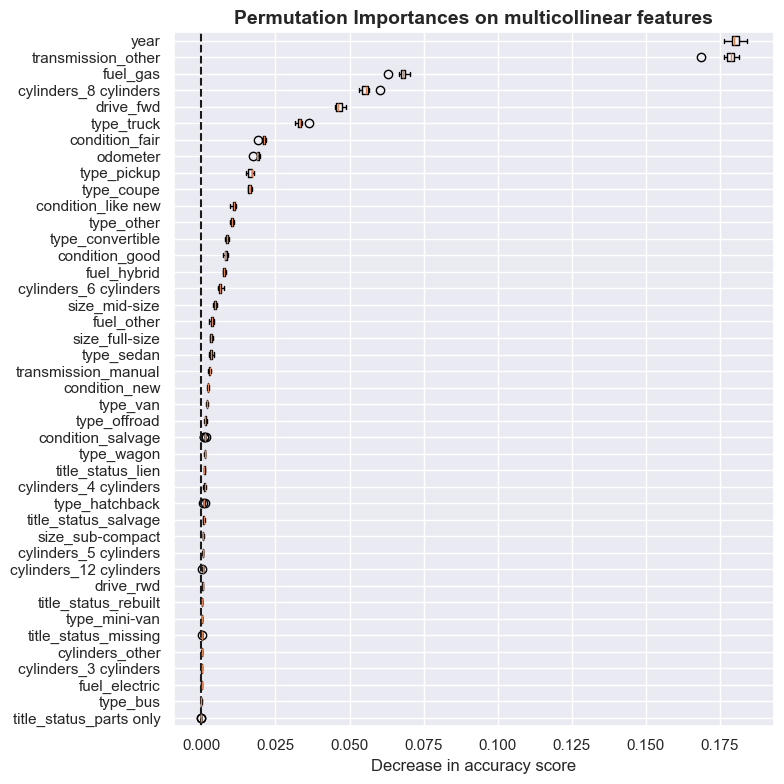

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_permutation_importance(p_imp, feature_names, p_imp_mean, ax)
ax.set_title("Permutation Importances on multicollinear features", fontdict=title_fonts)
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

plt.savefig('images/permutation_importance.png')
plt.show()

### Comparing Feature / Permutation Importance

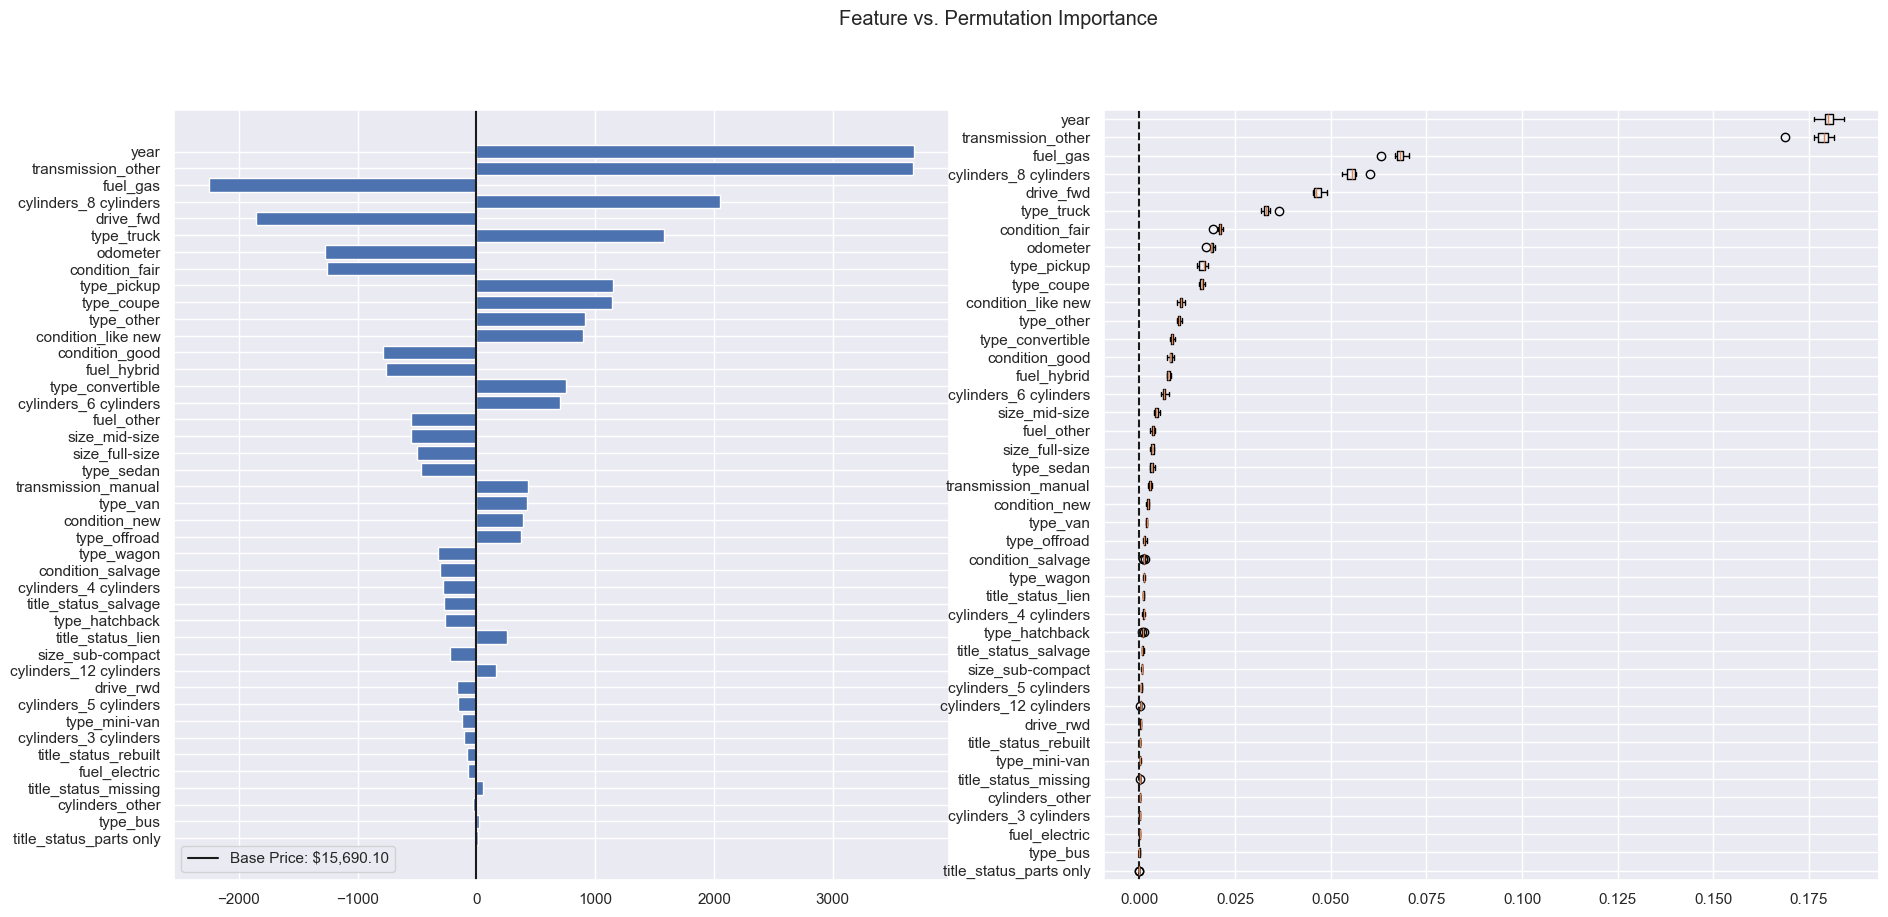

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))

fig.suptitle('Feature vs. Permutation Importance', fontdict=title_fonts)
# feature importance
ax1.barh(feature_imp_df['Feature'], feature_imp_df['Coefficient'])
ax1.axvline(x=0, color="k", linestyle="-", label=f'Base Price: ${y_intercept:,.2f}')

# ax1.set_xlabel(f'Pos / Neg Impact of Individual Feature on Base Price', fontdict=axes_fonts)
# ax1.set_ylabel('Feature by Importance on Price', fontdict=axes_fonts)

ax1.set_title('')
ax1.invert_yaxis()
ax1.legend(loc='lower left')

# perm imp
plot_permutation_importance(p_imp, feature_names, p_imp_mean, ax2)
ax2.set_title('')
# ax2.set_xlabel("Decrease in accuracy score", fontdict=axes_fonts)

_ = ax.figure.tight_layout()

plt.savefig('images/feature_perm_importance.png')
plt.show()

## Feature Elimination

Based on the above side-by-side comparison of the feature and permutation importance, we can see that a majority of the price is determeined by a relatively few features. Taking a look at the features that drive 85% of the price variance, the following features stand out, with different values impacting the price:

* Odometer
* Year
* Condition
* Transmission
* Type
* Drive
* Fuel
* Cylinders

Based on the permutation importance, the other features can be eliminated as they are mostly colinear and detract from the accuracy score.

Interestingly:

* `title_status` was eliminated likely due to the vast majority of the cars having a 'clean' title
* `size` is likely being over-shadowed by `transmission` and `cylinders` due to colinearity

Let's run the best model again after removing unnecessary features: `title_status`, `size`

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122682 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         122682 non-null  int64   
 1   year          122682 non-null  int64   
 2   condition     122682 non-null  category
 3   cylinders     122682 non-null  category
 4   fuel          122682 non-null  category
 5   odometer      122682 non-null  int64   
 6   title_status  122682 non-null  category
 7   transmission  122682 non-null  category
 8   drive         122682 non-null  category
 9   size          78626 non-null   category
 10  type          122682 non-null  category
dtypes: category(8), int64(3)
memory usage: 4.7 MB


## Segmentation Analysis

We define a couple of utility functions below to ...

In [70]:
def fit_plot_segments(segment_dict, results_seg, filename=False):
    """
    Predict and plot prices for selected segment

    :param segment_dict: Dictionary containg segment data and plot information
    :param results_seg: Array to append to for tabulating results
    :param filename: Optional filename to save the plot
    :returns: Returns the results table that was passed in
    """

    # logging.getLogger().setLevel(logging.DEBUG)

    plt.figure(figsize=(page_width,6))
    # plt.figure(figsize=(8,8))
    
    results_seg = []
    for segment in segment_dict['seg_data']:
        logging.debug(f"Segment: {segment}, #Samples: {len(segment_dict['seg_data'][segment])}")
    
        if len(segment_dict['seg_data'][segment]) <= 0:
            return results_seg
        
        # Predict on the segment
        X = segment_dict['seg_data'][segment].drop('price', axis='columns')
        y = segment_dict['seg_data'][segment]['price']
        logging.debug(f'X: {X.shape} y: {y.shape}')
    
        # transform the data: OneHotEncoding
        X = pd.get_dummies(X, drop_first=True)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
        logging.debug(f'X_train: {X_train.shape} X_test: {X_test.shape} y_train: {y_train.shape} y_test: {y_test.shape}')
    
        # Scale the data
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.fit_transform(X_test)
        logging.debug(f'X_scaled: {X_train_scaled.shape} X_test_scaled: {X_test_scaled.shape}')
    
        best_model.fit(X_train_scaled, y_train)
        
        # Plot predictions
        y_preds = best_model.predict(X_test_scaled)
        score = best_model.score(X_test_scaled, y_test)
        r2 = r2_score(y_test, y_preds)
        y_intercept = best_model.intercept_
        logging.debug(f'Score: {score}, r2: {r2}, y_int: {y_intercept}')
        y_preds = y_preds + y_intercept
    
        # results_seg[segment_name, #samples, R2, y-intercept, mean-price]
        results_seg.append([segment, len(segment_dict['seg_data'][segment]), r2*100, y_intercept, y_preds.mean()])
    
        perfect_pt_1 = [min(y_test), max(y_test)]
        # perfect_pt_2 = [min(y_test), max(y_test)]
        perfect_pt_2 = [min(y_test), max(y_test)] + y_intercept
        plt.scatter(x=y_test, y=y_preds, label=f'{segment} / ${y_intercept:,.2f}', alpha=0.5)
        plt.plot(perfect_pt_1, perfect_pt_2, linestyle='--', color='red')
    
    plt.xlabel(segment_dict['graph_x_label'], fontdict=axes_fonts)
    plt.ylabel(segment_dict['graph_y_label'], fontdict=axes_fonts)
    plt.title(segment_dict['graph_title'], fontdict=title_fonts)
    plt.legend().set_title('Price Segments / Base Price')
    plt.tight_layout()

    if (filename):
        plt.savefig(filename)
        
    plt.show()

    return results_seg

logging.getLogger().setLevel(logging.INFO)

In [71]:
def generate_segments_table(results_seg, png_filename=False):
    """
    Generate results table for the selected data segment

    :param results_seg: Results array that will be appropriately converted to a DataFrame
    :param png_filename: Optional filename to save the results DF
    :returns: Returns the styled DF
    """
    results_seg_df = pd.DataFrame(results_seg,
                                  columns=[segment, '# Cars', 'R2 Score', 'Base Price', 'Avg Price'])
    results_seg_df.set_index(results_seg_df.columns[0], inplace=True)
    
    # Export results for README
    results_seg_df_styled = my_utils.df_style_floats(results_seg_df)
    
    if (png_filename):
        dfi.export(results_seg_df_styled, png_filename)

    return results_seg_df_styled

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122682 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   price         122682 non-null  int64   
 1   year          122682 non-null  int64   
 2   condition     122682 non-null  category
 3   cylinders     122682 non-null  category
 4   fuel          122682 non-null  category
 5   odometer      122682 non-null  int64   
 6   title_status  122682 non-null  category
 7   transmission  122682 non-null  category
 8   drive         122682 non-null  category
 9   size          78626 non-null   category
 10  type          122682 non-null  category
dtypes: category(8), int64(3)
memory usage: 4.7 MB


In [73]:
# drop_cols = ['title_status', 'size']
drop_cols = ['title_status']
data.drop(columns=drop_cols, inplace=True)

In [74]:
# Eliminated Features segment

elim_segments = {
    'Eliminated Features': data
}

graph_x_label = 'Actual Prices'
graph_y_label = 'Predicted Prices'
elim_title = 'Eliminated Features: Predictions vs Actuals'

segments_dict = {
    'Eliminated Features': {
        'seg_data': elim_segments,
        'graph_title': elim_title,
        'graph_x_label': graph_x_label,
        'graph_y_label': graph_y_label,
        'graph_filename': 'images/scatter-segments-elim-preds-v-test.png',
        'seg_results': [],
        'results_table_title': elim_title,
        'results_table_filename': 'images/results_elim_segments.png'
    }
}

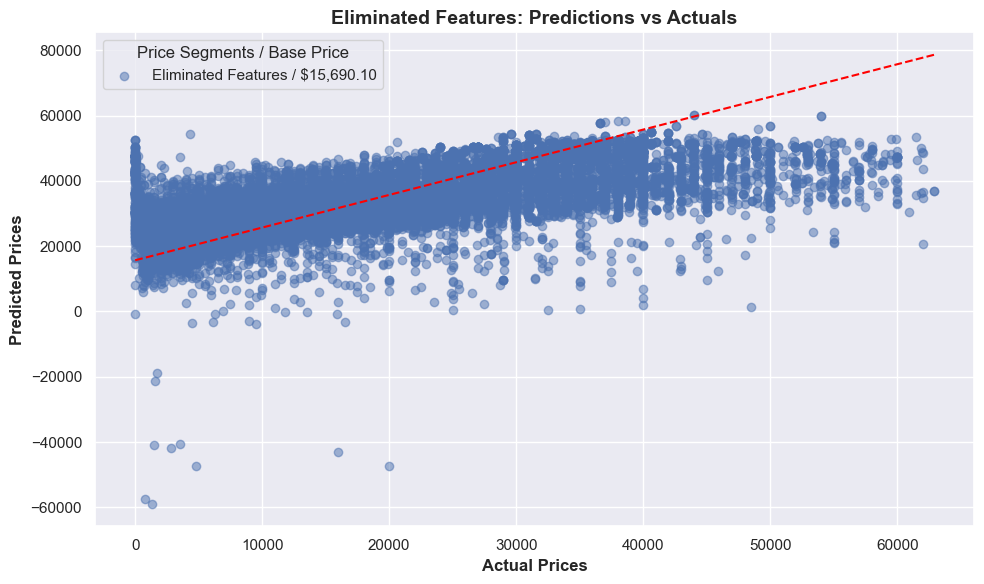

In [75]:
# Plot segments in single graph
segment = 'Eliminated Features'
segments_dict[segment]['seg_results'] = fit_plot_segments(segments_dict[segment], 
                                                          segments_dict[segment]['seg_results'],
                                                          segments_dict[segment]['graph_filename'])

In [76]:
# generate results table
seg_df = generate_segments_table(segments_dict[segment]['seg_results'], png_filename=segments_dict[segment]['results_table_filename'])
print(segments_dict[segment]['results_table_title'])
seg_df

Eliminated Features: Predictions vs Actuals


,# Cars,R2 Score,Base Price,Avg Price
Eliminated Features,,,,
Eliminated Features,122682,51.97067,"15,690.10098","31,380.20197"


### Market Defined Segments

In [78]:
# Market Defintion of car segementations typical in the used car sales business

mkt_segments = {
    'Budget': data.query('year <= 2016 and odometer >= 80000'),
    'Entry': data.query('(year>=2016 and year<=2019) and (odometer>=60000 and odometer<=80000)'),
    'Mid': data.query('(year>=2019 and year<=2021) and (odometer>=30000 and odometer<=60000)'),
    'Premium': data.query('(year>=2021 and year<=2024) and (odometer<=30000)'),
}

graph_x_label = 'Actual Prices'
graph_y_label = 'Predicted Prices'
mkt_title = 'Market Segments: Predictions vs Actuals'

segments_dict = {
    'Market Segments': {
        'seg_data': mkt_segments,
        'graph_title': mkt_title,
        'graph_x_label': graph_x_label,
        'graph_y_label': graph_y_label,
        'graph_filename': 'images/scatter-segments-mkt-preds-v-test.png',
        'seg_results': [],
        'results_table_title': mkt_title,
        'results_table_filename': 'images/results_mkt_segments.png'
    }
}

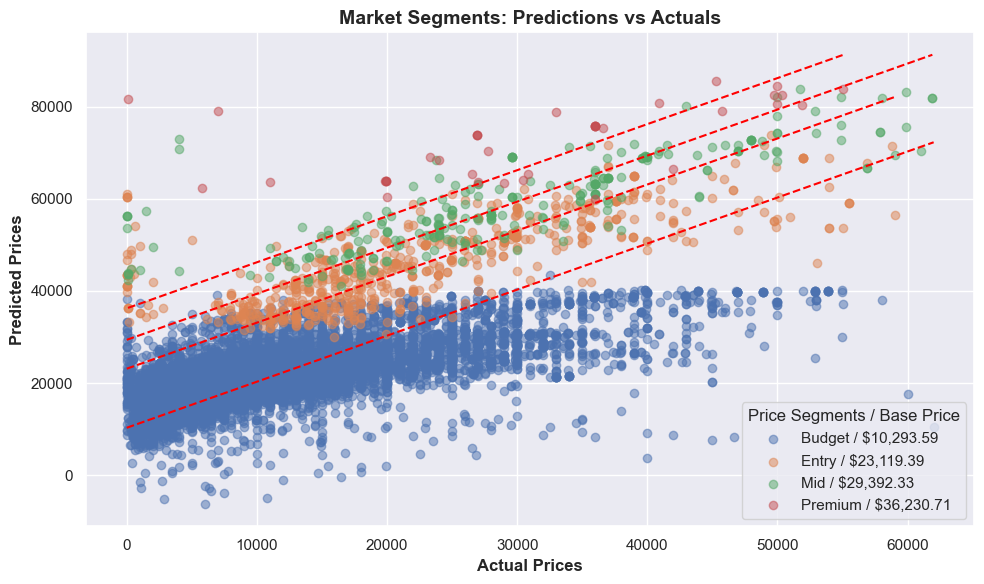

In [79]:
# Plot segments in single graph
segment = 'Market Segments'
segments_dict[segment]['seg_results'] = fit_plot_segments(segments_dict[segment], 
                                                          segments_dict[segment]['seg_results'],
                                                          segments_dict[segment]['graph_filename'])

In [80]:
# generate results table
seg_df = generate_segments_table(segments_dict[segment]['seg_results'], png_filename=segments_dict[segment]['results_table_filename'])
print(segments_dict[segment]['results_table_title'])
seg_df

Market Segments: Predictions vs Actuals


,# Cars,R2 Score,Base Price,Avg Price
Market Segments,,,,
Budget,75933,48.95516,"10,293.59398","20,587.18796"
Entry,3480,59.12237,"23,119.38721","46,238.77443"
Mid,1295,66.12802,"29,392.33301","58,784.66602"
Premium,188,17.33667,"36,230.71333","72,461.42667"


### Price-based Segments

In [82]:
# Define segments
mid_boundary = 5000
high_boundary = 40000
price_segments = {
    'Low-priced': data.query('price > 0 and price < @mid_boundary'),
    'Mid-priced': data.query('price >= @mid_boundary and price < @high_boundary'),
    'High-priced': data.query('price >= @high_boundary'),
}

price_title = 'Price Segments: Predictions vs Actuals'

segments_dict = {
    'Price Segments': {
        'seg_data': price_segments,
        'graph_title': price_title,
        'graph_x_label': graph_x_label,
        'graph_y_label': graph_y_label,
        'graph_filename': 'images/scatter-segments-price-preds-v-test.png',
        'seg_results': [],
        'results_table_title': price_title,
        'results_table_filename': 'images/results_price_segments.png'
    }
}

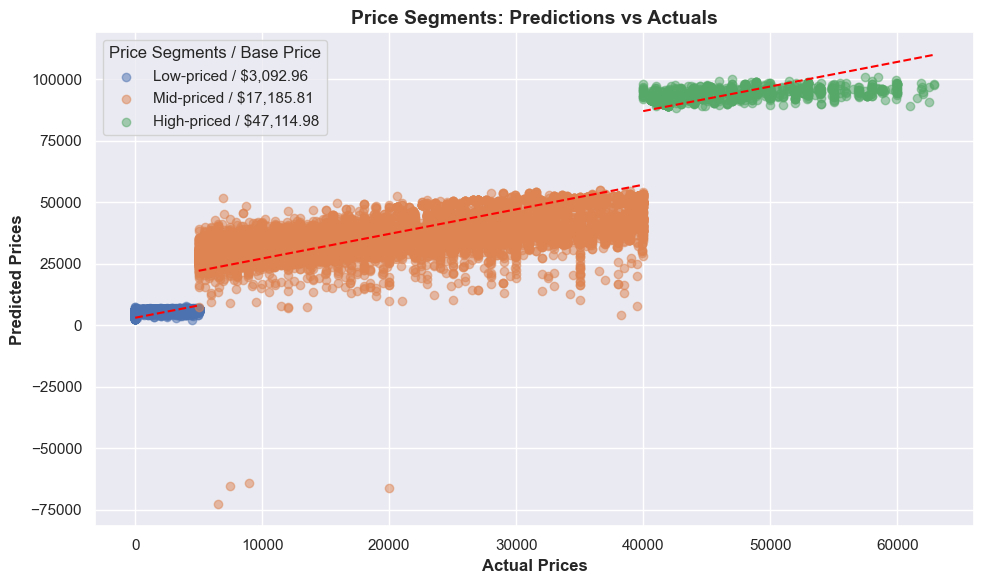

In [83]:
# Plot segments in single graph
segment = 'Price Segments'
segments_dict[segment]['seg_results'] = fit_plot_segments(segments_dict[segment], 
                                                          segments_dict[segment]['seg_results'],
                                                          segments_dict[segment]['graph_filename'])

In [84]:
# generate results table
seg_df = generate_segments_table(segments_dict[segment]['seg_results'], png_filename=segments_dict[segment]['results_table_filename'])
print(segments_dict[segment]['results_table_title'])
seg_df

Price Segments: Predictions vs Actuals


,# Cars,R2 Score,Base Price,Avg Price
Price Segments,,,,
Low-priced,23298,15.75442,"3,092.96158","6,185.92317"
Mid-priced,94441,52.43751,"17,185.80583","34,371.61166"
High-priced,4943,17.44493,"47,114.97547","94,229.95094"


### Validation Dataset: Defining the Null Data Segment

If you go back and see how we cleaned the initial data set, we used `dropna()` to remove all nulls from the following columns before modeling to get a clean, high-quality dataset:

In [87]:
dropna_cols

['condition', 'cylinders', 'drive', 'type']

At that time we had saved a copy of the rows that had atleast one column with a null value but included prices - we can treat this as a *validation dataset* to use our best model to predict prices. This is a good benchmark to see how it would do forecasting pricing for new autos that didn't have all the car attributes defined!

In [89]:
# Define the data segement for rows with prices, but atleast one null-value column
nulls_segment = {
    'Data with Nulls': data_with_nulls
}

Null_title = 'Null Data Segment: Predictions vs Actuals'

segments_dict = {
    'Null Data Segments': {
        'seg_data': nulls_segment,
        'graph_title': Null_title,
        'graph_x_label': graph_x_label,
        'graph_y_label': graph_y_label,
        'graph_filename': 'images/scatter-segments-nulls-preds-v-test.png',
        'seg_results': [],
        'results_table_title': Null_title,
        'results_table_filename': 'images/results_nulls_segments.png'
    }
}

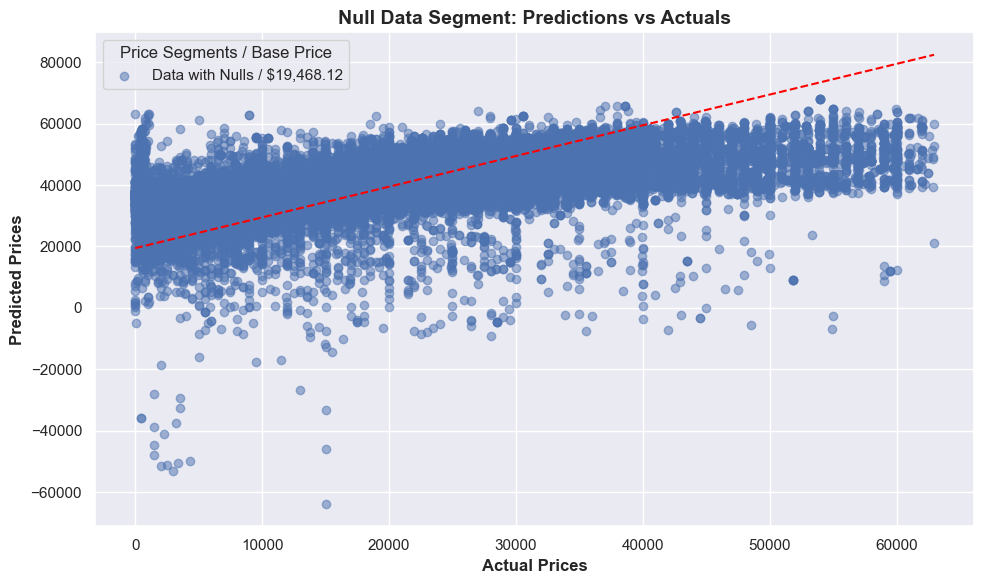

In [90]:
# Plot segments in single graph
segment = 'Null Data Segments'
segments_dict[segment]['seg_results'] = fit_plot_segments(segments_dict[segment], 
                                                          segments_dict[segment]['seg_results'],
                                                          segments_dict[segment]['graph_filename'])

In [91]:
# generate results table
seg_df = generate_segments_table(segments_dict[segment]['seg_results'], png_filename=segments_dict[segment]['results_table_filename'])
print(segments_dict[segment]['results_table_title'])
seg_df

Null Data Segment: Predictions vs Actuals


,# Cars,R2 Score,Base Price,Avg Price
Null Data Segments,,,,
Data with Nulls,282074,43.16886,"19,468.11861","38,936.23723"
